In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.preprocessing import StandardScaler, normalize
from scipy.signal import find_peaks
from scipy.signal import lfilter, butter
import seaborn as sns
import os, glob

import imageio

from tqdm import tqdm_notebook

import warnings
warnings.filterwarnings("ignore")

In [2]:
path = r'C:\Users\ecath\Desktop\Research\Raw Data\LD dataset'

data_list = []
for filename in glob.glob(os.path.join(path, '*.csv')):
    data = pd.read_csv(filename, header=0)
    data.rename(columns=lambda x: x.replace(' ', '_'), inplace=True)
    data.rename(columns=lambda x: x.replace('_O', '_opt'), inplace=True)
    data.rename(columns=lambda x: x.replace('.', '_opt_'), inplace=True)
    data.rename(columns=lambda x: x.replace('Bsk', filename + '_Bsk'), inplace=True)
    data.rename(columns=lambda x: x.replace(path, ''), inplace=True)
    data.rename(columns=lambda x: x.replace('.csv', ''), inplace=True)
    data.rename(columns=lambda x: x.replace(' ', '_'), inplace=True)
    data.rename(columns=lambda x: x.replace('_annot', ''), inplace=True)
    data.rename(columns=lambda x: x.replace('\\', ''), inplace=True)
    print(filename, data.shape)
    data_list.append(data)


C:\Users\ecath\Desktop\Research\Raw Data\LD dataset\1.csv_annot.csv (10173, 192)
C:\Users\ecath\Desktop\Research\Raw Data\LD dataset\10_Epi.csv_annot.csv (8191, 192)
C:\Users\ecath\Desktop\Research\Raw Data\LD dataset\11_Endo.csv_annot.csv (10173, 192)
C:\Users\ecath\Desktop\Research\Raw Data\LD dataset\12_Epi.csv_annot.csv (10173, 192)
C:\Users\ecath\Desktop\Research\Raw Data\LD dataset\15_Endo.csv_annot.csv (8191, 192)
C:\Users\ecath\Desktop\Research\Raw Data\LD dataset\16_Epi.csv_annot.csv (8191, 192)
C:\Users\ecath\Desktop\Research\Raw Data\LD dataset\17_Endo.csv_annot.csv (10173, 192)
C:\Users\ecath\Desktop\Research\Raw Data\LD dataset\18_Epi.csv_annot.csv (10173, 192)
C:\Users\ecath\Desktop\Research\Raw Data\LD dataset\22.csv_annot.csv (16667, 192)
C:\Users\ecath\Desktop\Research\Raw Data\LD dataset\23.csv_annot.csv (16383, 192)
C:\Users\ecath\Desktop\Research\Raw Data\LD dataset\24.csv_annot.csv (18311, 192)
C:\Users\ecath\Desktop\Research\Raw Data\LD dataset\25.csv_annot.csv (1

In [3]:
"""
Function performs bandpass filter for the digital signal 

Parameters: 
-----------
data: array_like
    An N-dimensional input array
lowcut: float
    Low cutoff frequency
highcut: float
    High cutoff frequency
fs: float
    Sampling rate of the signal
order: int
    The order of the filter.

Returns: 
-------
filtered_signal: array
    The output of the digital filter
"""

def butter_bandpass(data, lowcut, highcut, fs, order=2):
    nyq = 0.5 * fs
    
    high = highcut / nyq
    low = lowcut / nyq
    
    b, a = butter(order, [low, high], btype='bandpass', analog=False)
    filtered_signal = lfilter(b, a, data)
    
    return filtered_signal



"""
Fill NaN with zeros

Parameters: 
-----------
df: DataFrame
    DataFrame with NaNs
    
Returns: 
-------
df: Dataframe
    All NaNs filled by zeros
"""

def del_nul_and_nan(df):
    
    df.fillna(value=0, axis=1, inplace=True)
    
################# add to drop off zero columns ######################    
#     for col in df.columns:
#         if df[col].sum() == 0:
#             df.drop([col], axis = 1, inplace = True)  
################# add to drop off zero columns ######################    
    
    return df


"""


Parameters: 
-----------
df: pd.DataFrame
    An N-dimensional input DataFrame
N: int
    Number of sample points
lowcut: float
    Low cutoff frequency
highcut: float
    High cutoff frequency
fs: float
    Sampling rate of the signal

Returns: 
-------
fft_out: pd.DataFrame
    An output Dataframe with spectrum and frequencies 
"""

def spec_and_freq_for_single_df(df, N, fs, lowcut, highcut):
    
    fft_out = pd.DataFrame()
    
    for col in df.columns:
        filtered_yf = butter_bandpass(df[col], lowcut, highcut, fs, order=2)
        
        
        fft_yf = np.fft.fft(filtered_yf) #spectrum
        fft_xf = np.fft.fftfreq(N, 1/fs) #frequencies
        
        fft_20_index = np.argwhere((fft_xf<25) & (fft_xf>0))        
        fft_yf_20 = fft_yf[fft_20_index] #cutting on 20Hz
        fft_xf_20 = fft_xf[fft_20_index] #cutting on 20Hz
        
        fft_yf_20 = pd.DataFrame(np.abs(fft_yf_20) / N, columns=[col + '_yf'])
        fft_xf_20 = pd.DataFrame(fft_xf_20, columns=[col + '_xf']) 

        fft_out = pd.concat([fft_out, fft_yf_20, fft_xf_20], axis=1)
        
    return(fft_out)


"""

Parameters: 
-----------
class_data_list: list
    List with DataFrames 
    
Returns: 
-------
all_fft_el, all_fft_om: list, list
    Lists with spectrum and frequencies DataFrames
"""

def full_spec_and_freq(class_data_list):
    
    all_fft_el = []
    all_fft_om = []

    for k, df in enumerate(class_data_list):

        electrode_signal = df[df.columns[::3]]
        optical_signal = df[df.columns[2::3]]

        electrode_signal = del_nul_and_nan(electrode_signal)
        optical_signal = del_nul_and_nan(optical_signal)        

        N = df.shape[0] # Number of sample points
        Fs_el = 1017.25 # sampling rate
        Fs_om = 1000.0

        fft_mem = spec_and_freq_for_single_df(electrode_signal, N, Fs_el, lowcut=1.5, highcut=22.0)
        fft_niom = spec_and_freq_for_single_df(optical_signal, N, Fs_om, lowcut=1.5, highcut=22.0)
        target_mem = pd.DataFrame(df[df.columns[1::3]].iloc[0, :].values, 
                                  index=fft_mem.iloc[:, ::2].columns, columns=['target']).transpose()
        target_niom = pd.DataFrame(df[df.columns[1::3]].iloc[0, :].values, 
                                   index=fft_niom.iloc[:, ::2].columns, columns=['target']).transpose()


        fft_mem = pd.concat([fft_mem, target_mem], axis=0)
        all_fft_el.append(fft_mem)
        fft_niom = pd.concat([fft_niom, target_niom], axis=0)
        all_fft_om.append(fft_niom)
        
        
    return(all_fft_el, all_fft_om)

In [4]:
mem_spectrum, _ = full_spec_and_freq(data_list)

In [5]:
_, niom_spectrum = full_spec_and_freq(data_list)

In [15]:
def max_freq(df_):
    df = df_.drop('target')
    target = df_.iloc[-1, 1::2]
    target.fillna(-1, inplace=True)
    y_col = [col for col in df.columns if '_yf' in col]
#     y_df = df[y_col]
    yf = df.iloc[:, 1::2]
    xf = df.iloc[:, ::2]
    freq = []
    for i in range(yf.shape[1]): 
        max_peak = np.argmax(yf.iloc[:, i])
        fr = xf.iloc[max_peak, i]
        freq.append(fr)
    freq = pd.DataFrame(freq, index=y_col)
    return freq, target

In [21]:
def snr(df_):
    df = df_.drop('target')
    target = df_.iloc[-1, 1::2]
    target.fillna(-1, inplace=True)
    y_col = [col for col in df.columns if '_yf' in col]
    y_df = df[y_col]
    snr = []
        
    for i in range(y_df.shape[1]):          
        s = y_df[y_col[i]][y_df[y_col[i]] != 0]

        _, properties = find_peaks(s, height=0)
        mean_max = np.mean(np.sort(properties['peak_heights'])[-2:])#np.max(properties['peak_heights'])
        sd = s.std(axis=0)
        ratio = np.round(mean_max / sd, 2)
        ratio = np.where(sd == 0, 0, ratio)
        snr.append(ratio)
    snr = pd.DataFrame(snr, columns=['SNR'], index=y_df.columns)
    return snr, target 

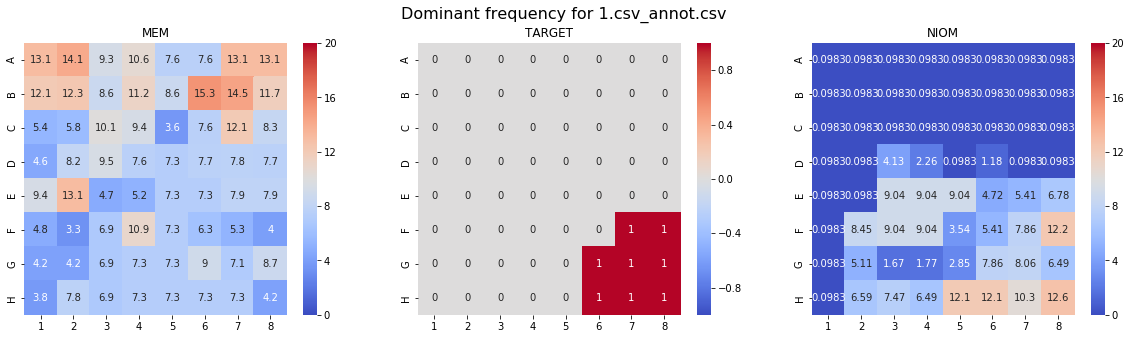

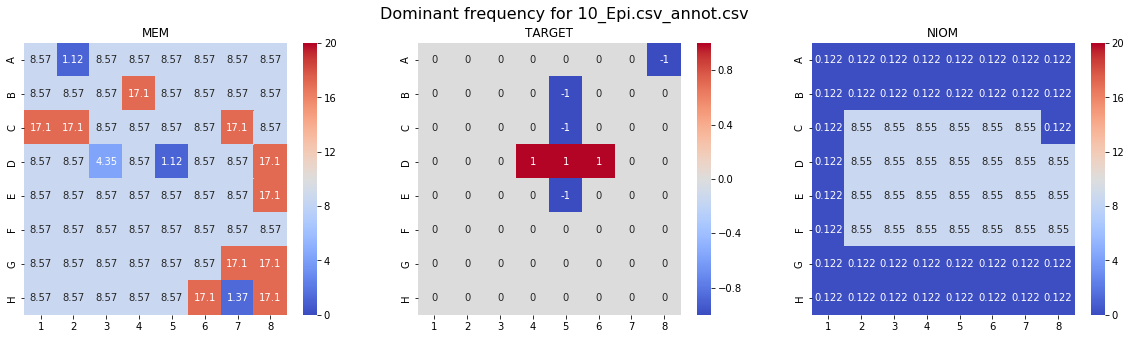

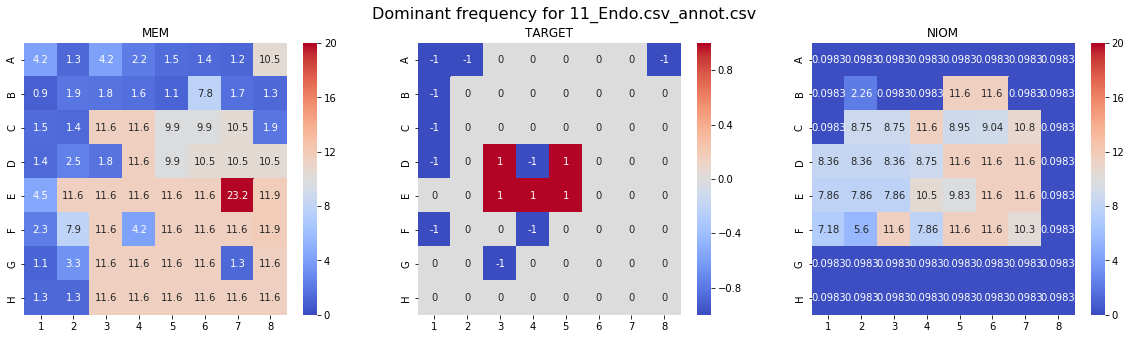

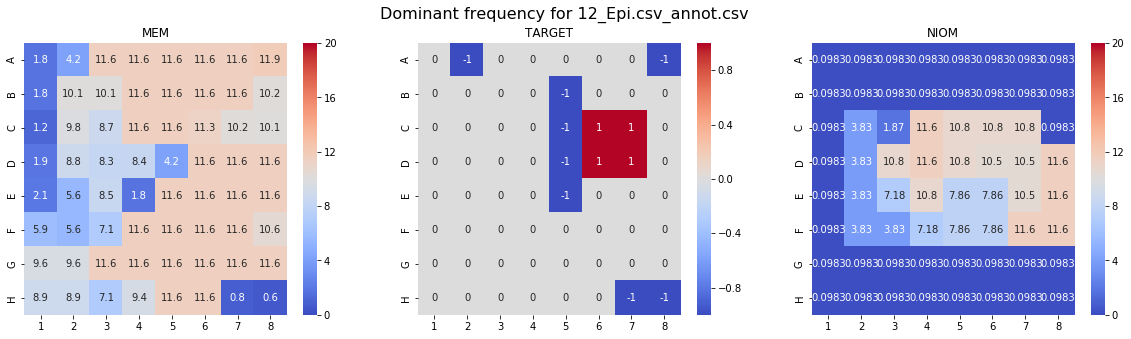

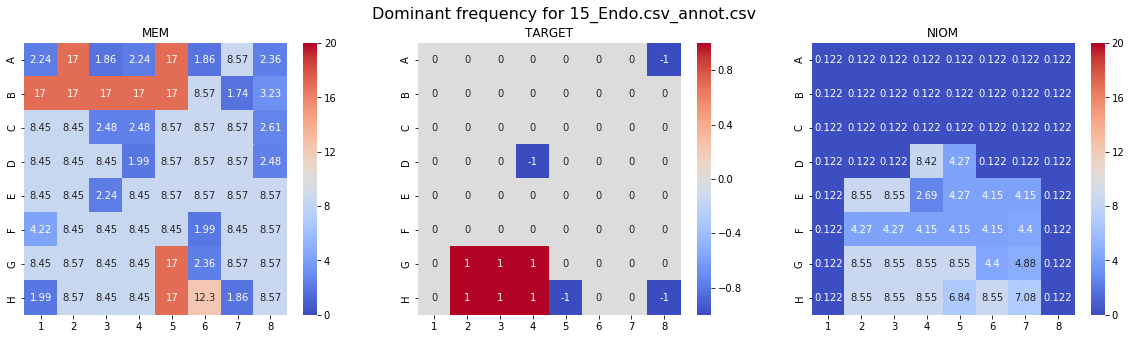

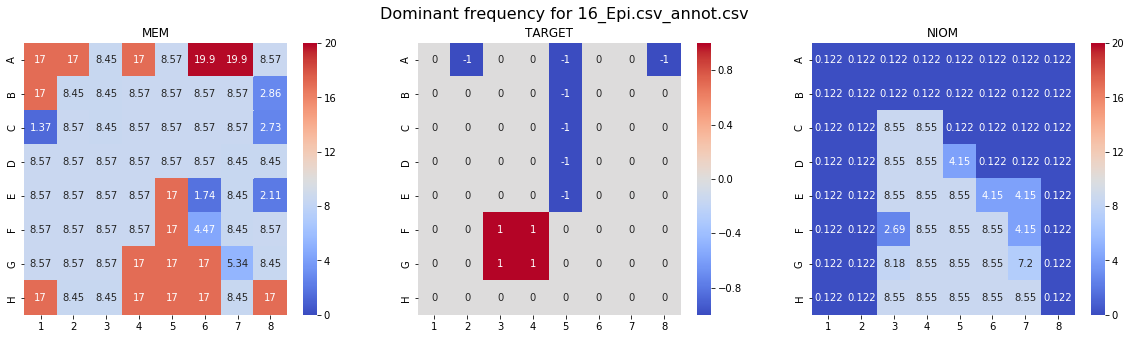

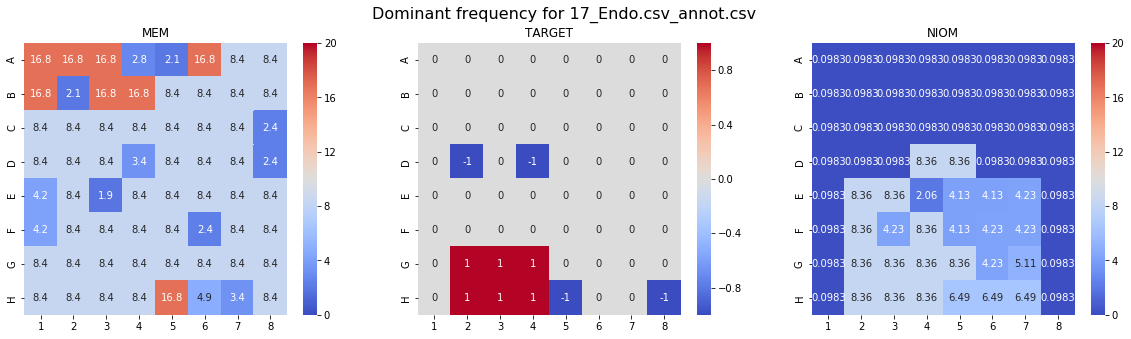

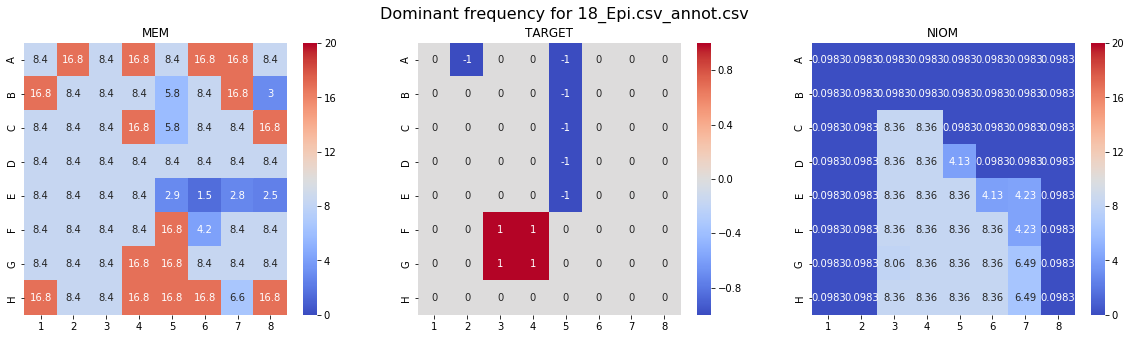

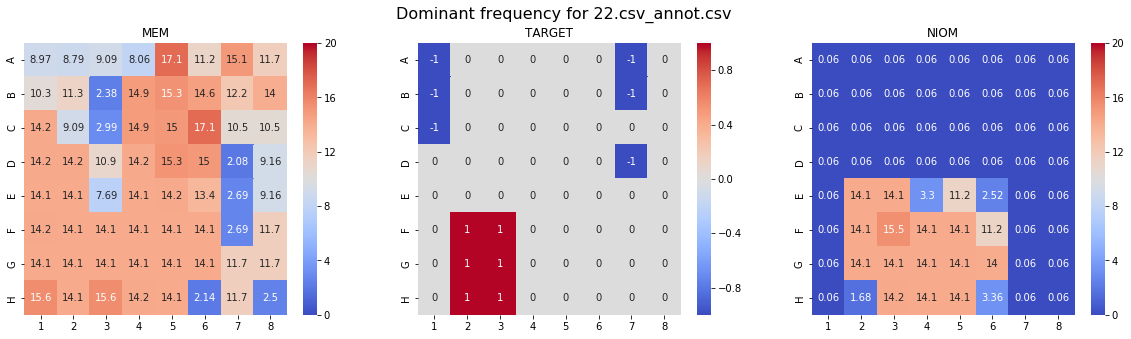

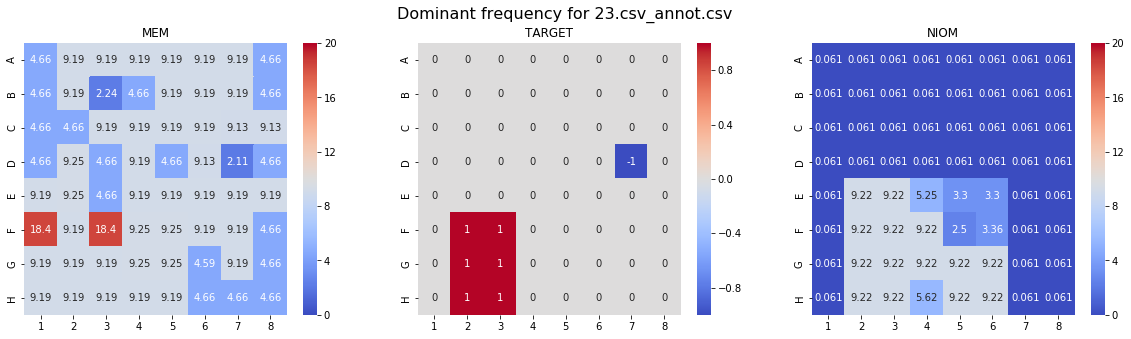

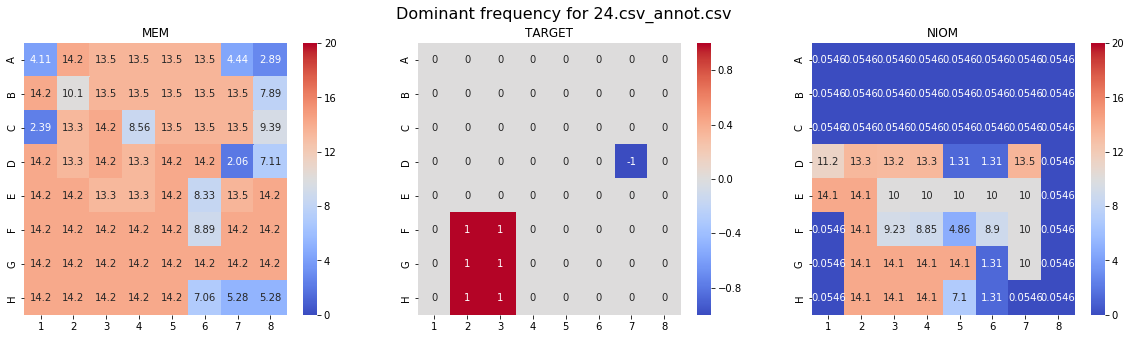

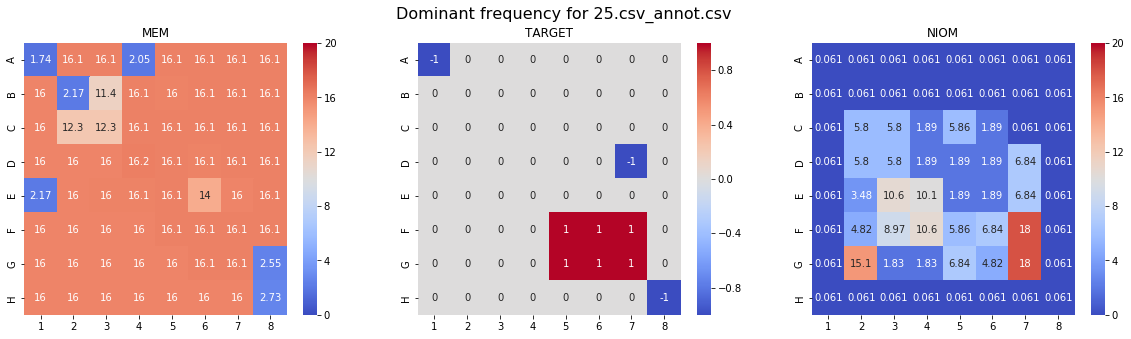

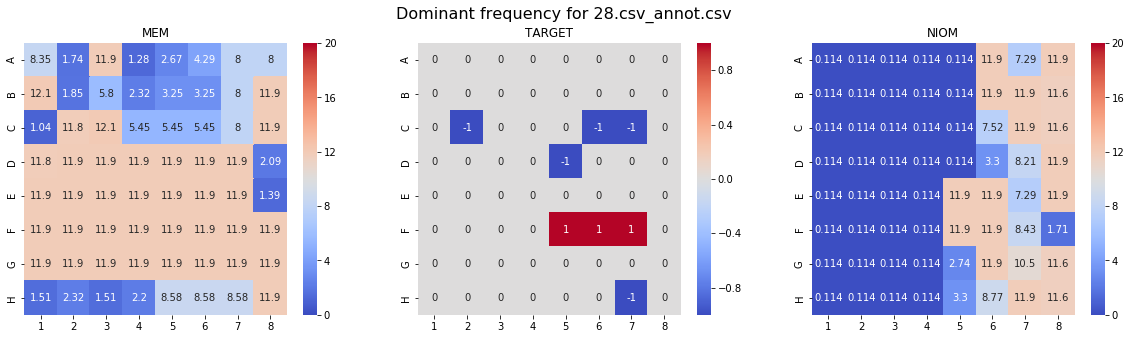

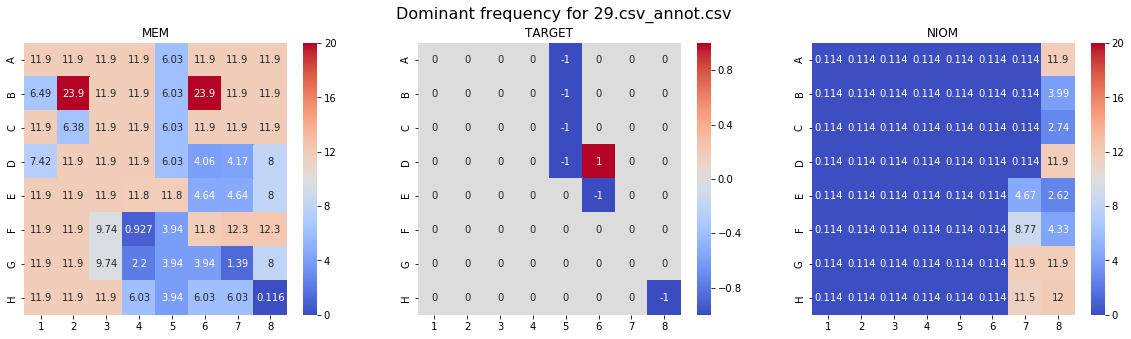

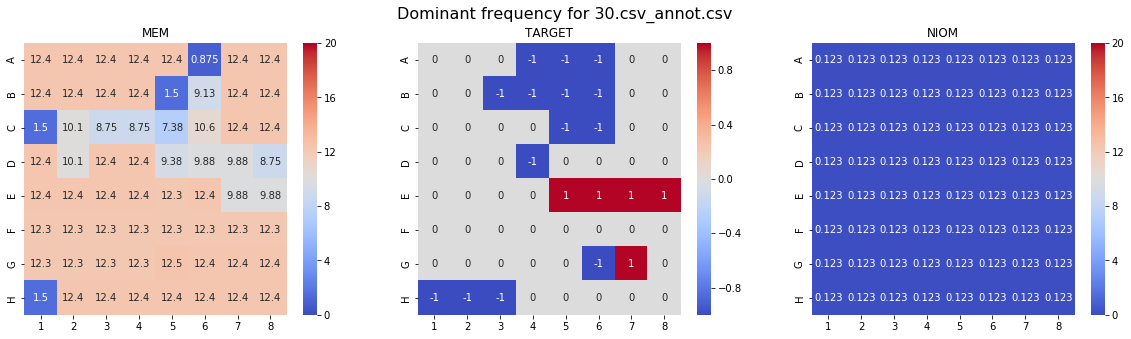

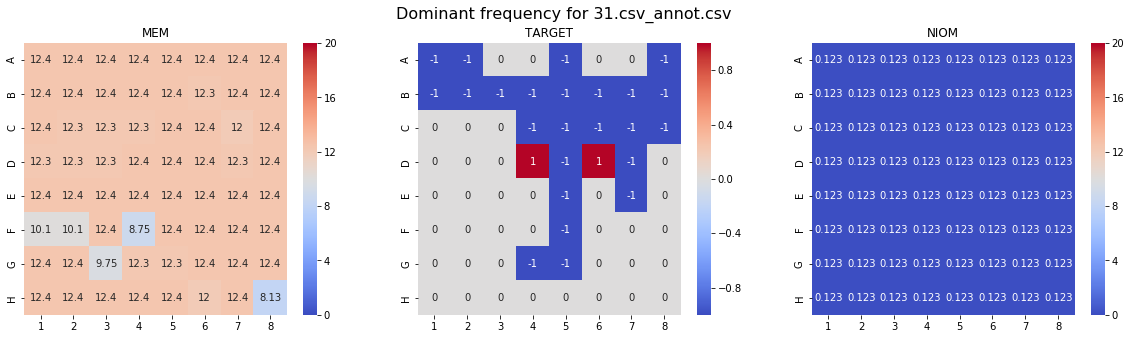

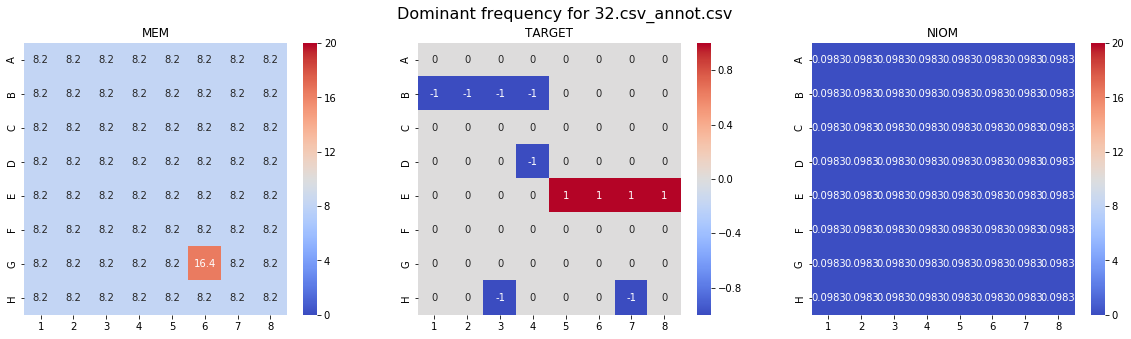

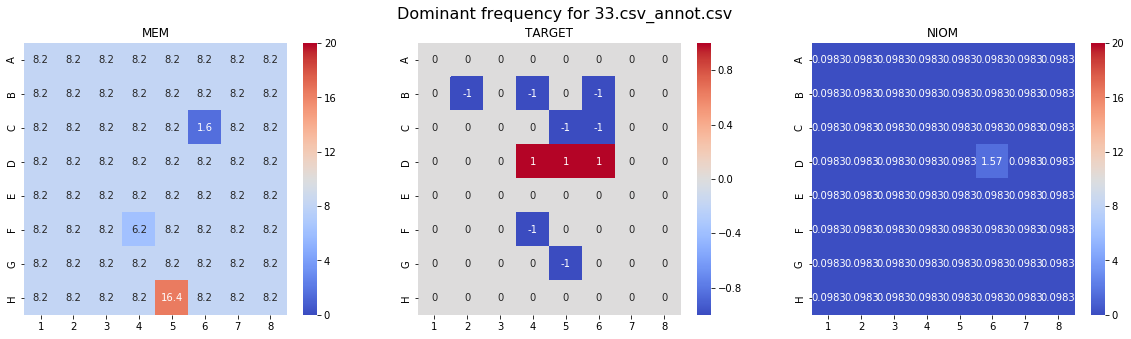

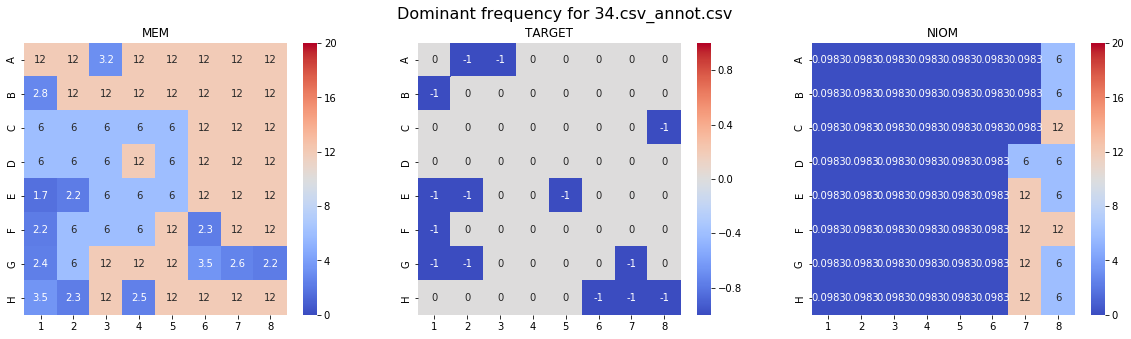

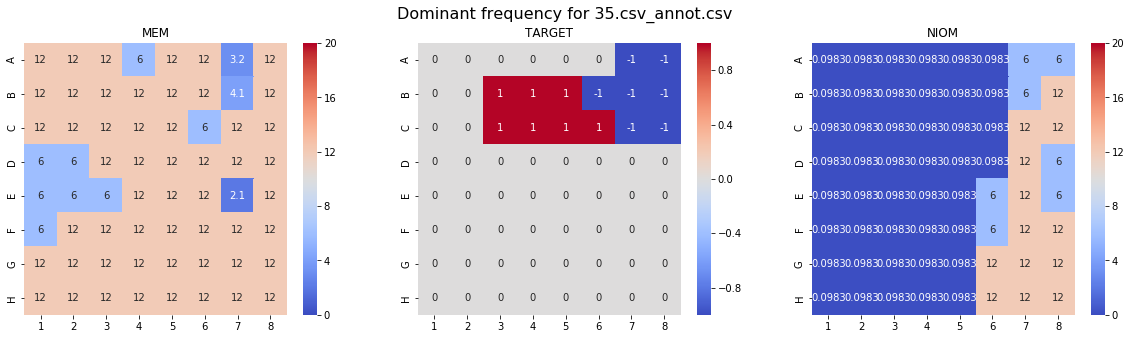

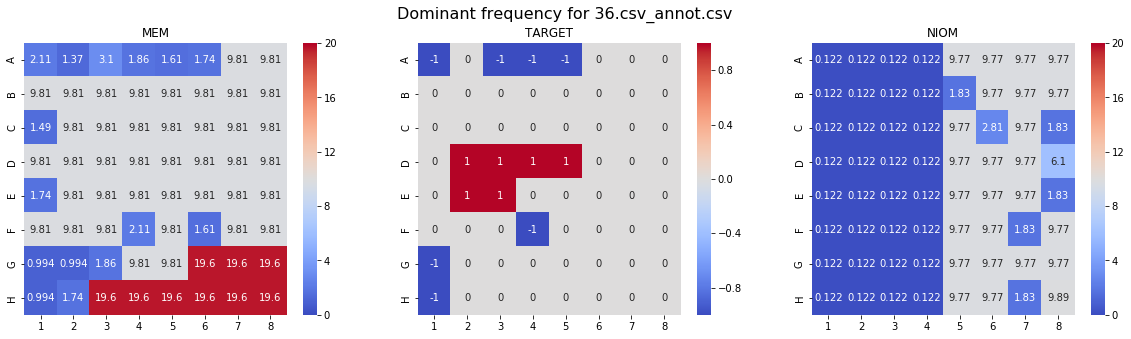

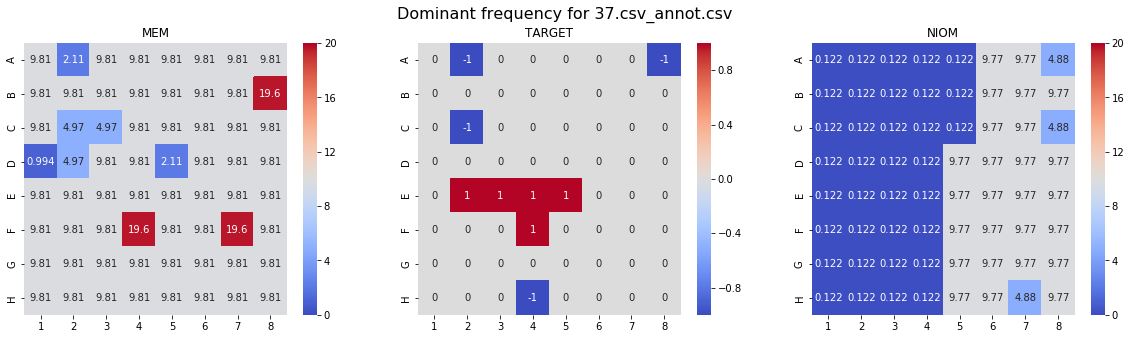

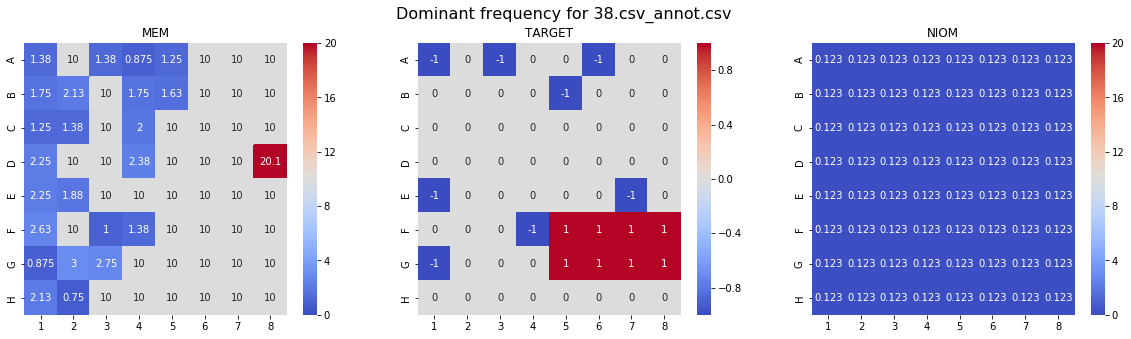

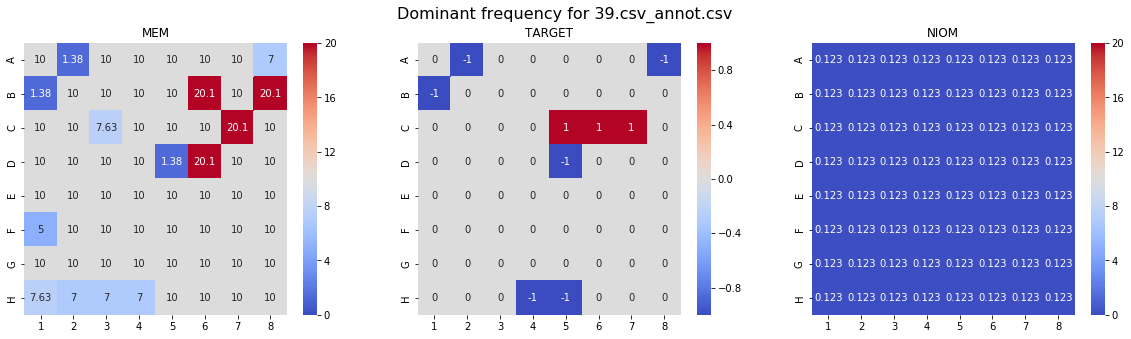

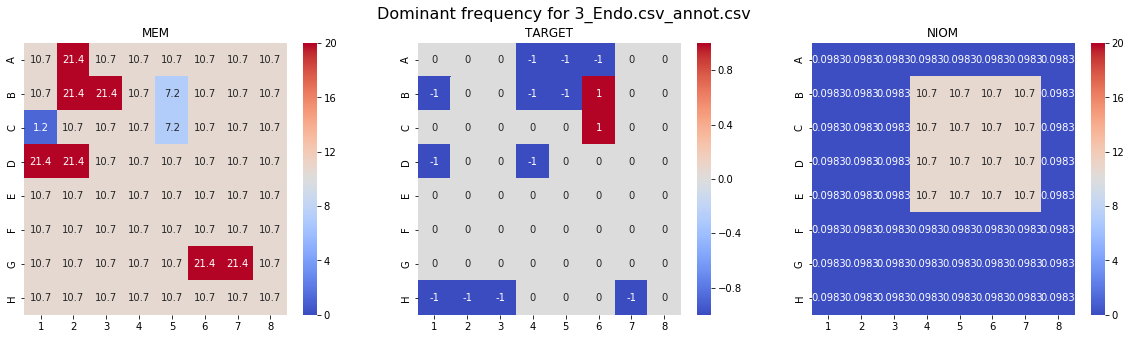

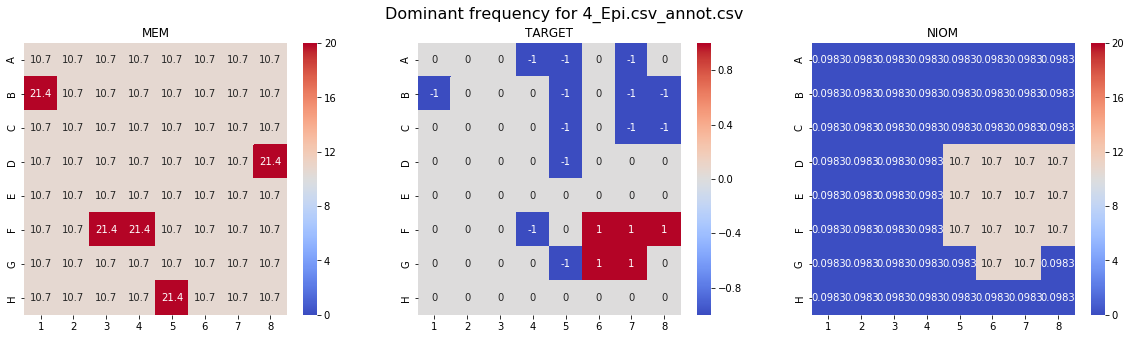

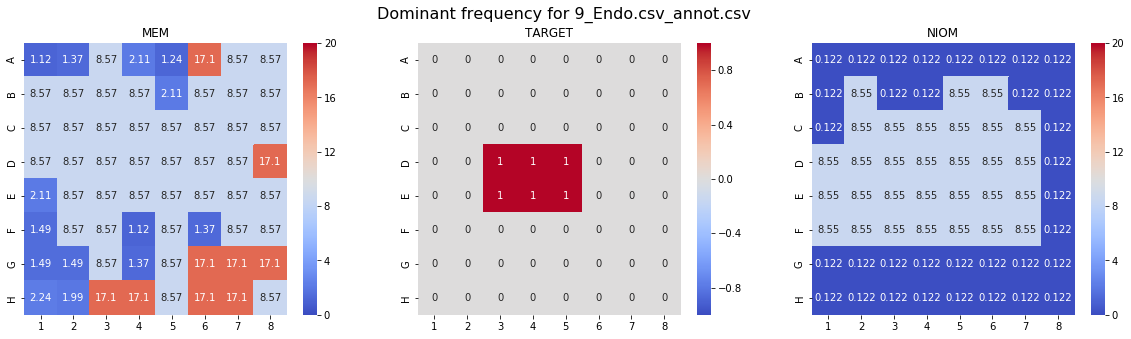

In [54]:
#heatmaps for MEM spectrum for dominant frequency parameter
path = r'C:\Users\ecath\Desktop\Research\Raw Data\LD dataset'
file_names = os.listdir(path)

for i in range(len(mem_spectrum)):
    dominant_freq_mem, target = max_freq(mem_spectrum[i])
    dominant_freq_niom, _ = max_freq(niom_spectrum[i])
    
    resized_mem = np.resize(dominant_freq_mem,(8,8)).transpose()
    resized_niom = np.resize(dominant_freq_niom,(8,8)).transpose()

    resized_target = np.resize(target,(8,8)).transpose()

    fig = plt.figure(figsize=(20, 5)) 
    ax1, ax2, ax3 = fig.subplots(1,3)

    fig.suptitle('Dominant frequency for ' + file_names[i], fontsize=16)

    pl1 = sns.heatmap(resized_mem, vmin=0, vmax=20, annot=True, 
                        xticklabels=np.arange(1, 9), 
                        yticklabels=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'], 
                        cmap="coolwarm", ax=ax1, fmt='.3g')
    ax1.set_title('MEM')
    
    pl2 = sns.heatmap(resized_niom, vmin=0, vmax=20, annot=True, 
                        xticklabels=np.arange(1, 9), 
                        yticklabels=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'], 
                        cmap="coolwarm", ax=ax3, fmt='.3g')
    
    ax3.set_title('NIOM')
    
    pl3 = sns.heatmap(resized_target, vmin=-1, vmax=1, center=0, annot=True,
                        xticklabels=np.arange(1, 9), 
                        yticklabels=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'], 
                        cmap="coolwarm", ax=ax2)
    
    ax2.set_title('TARGET')
    
    plt.savefig(r'C:\Users\ecath\Desktop\Research\Raw Data' + '\\' + file_names[i] + ' dom_freq.png', format='png' )
    
    plt.show()


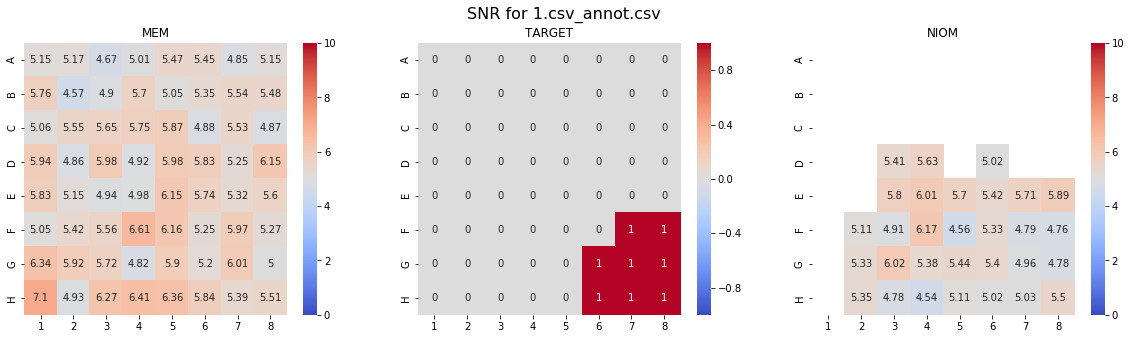

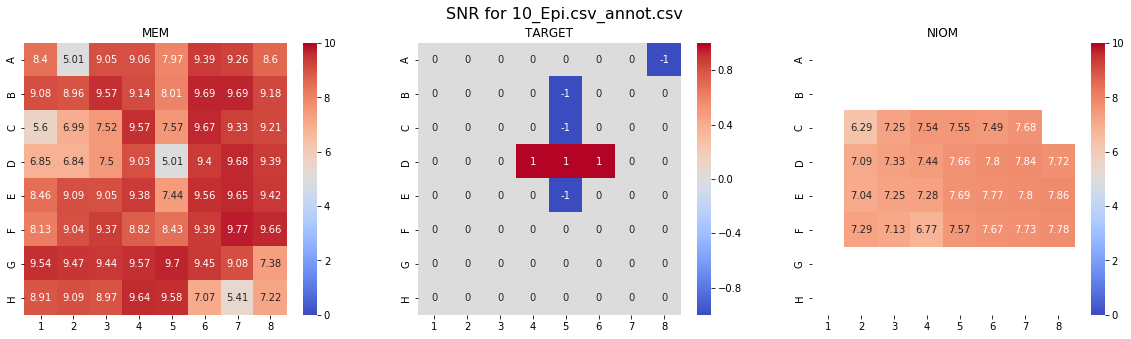

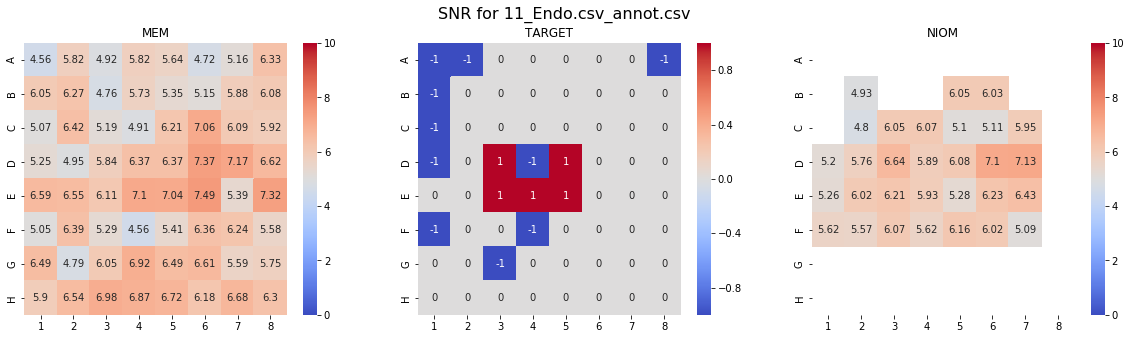

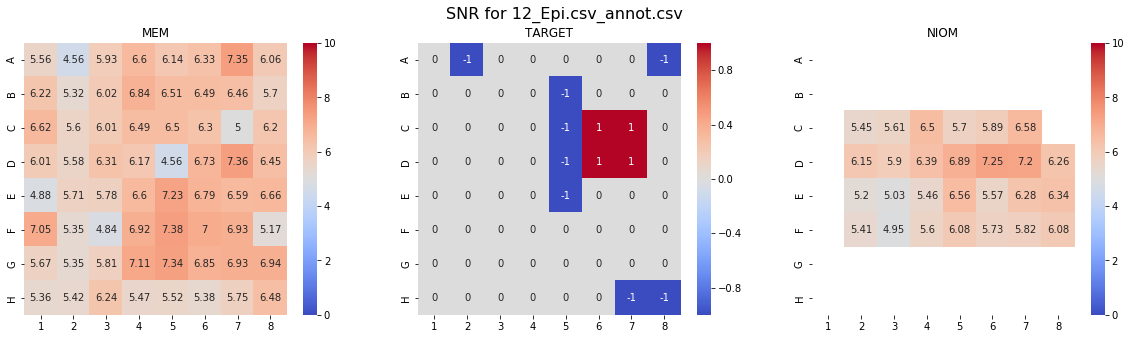

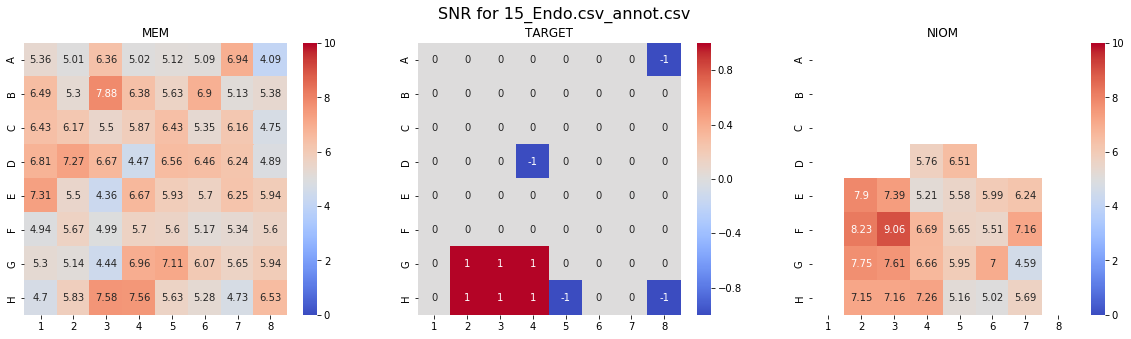

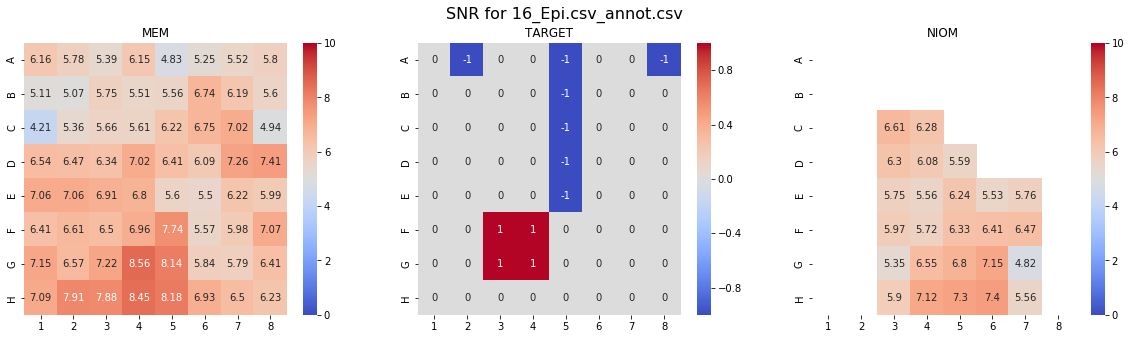

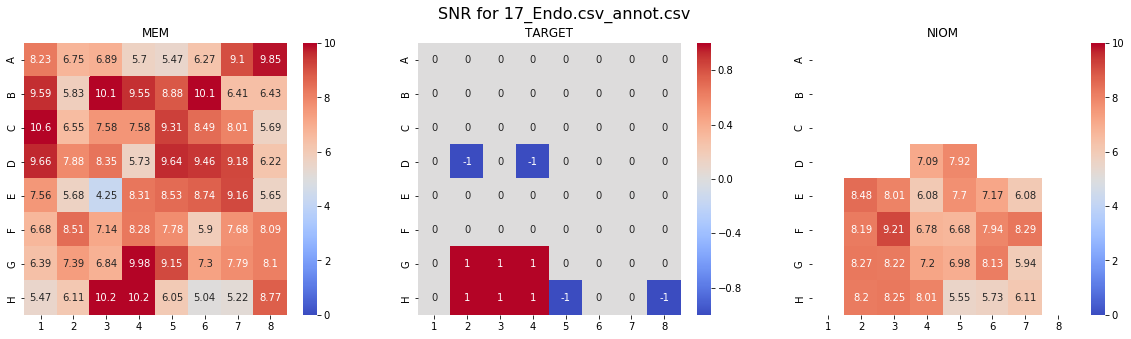

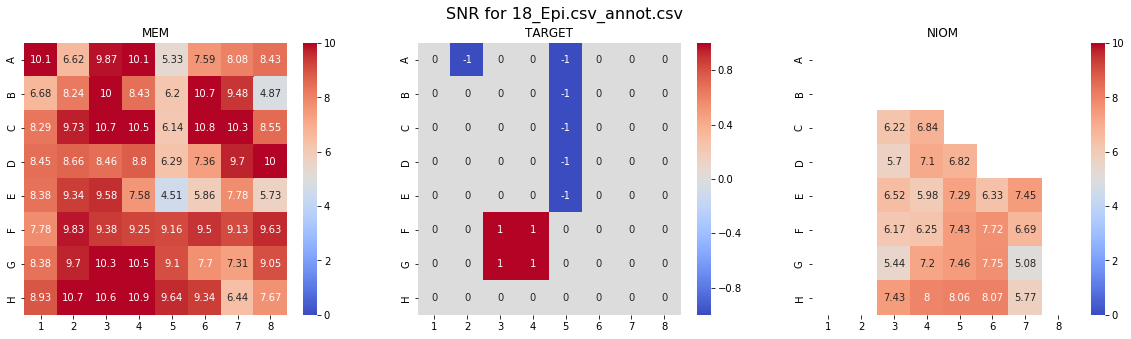

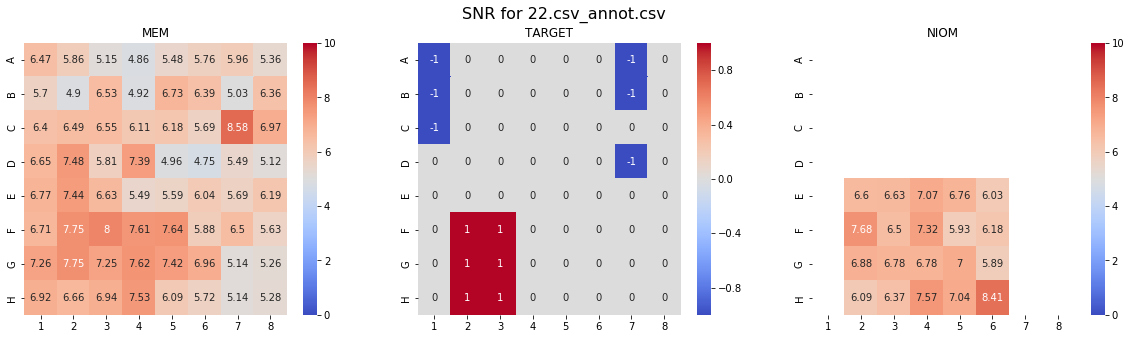

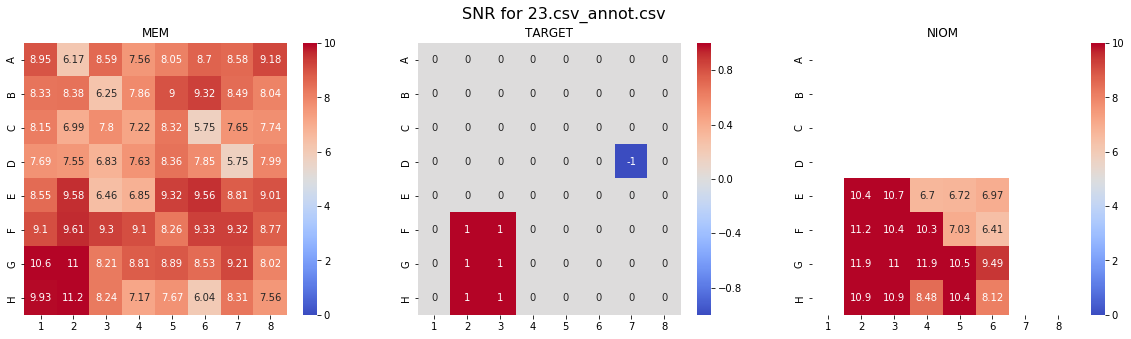

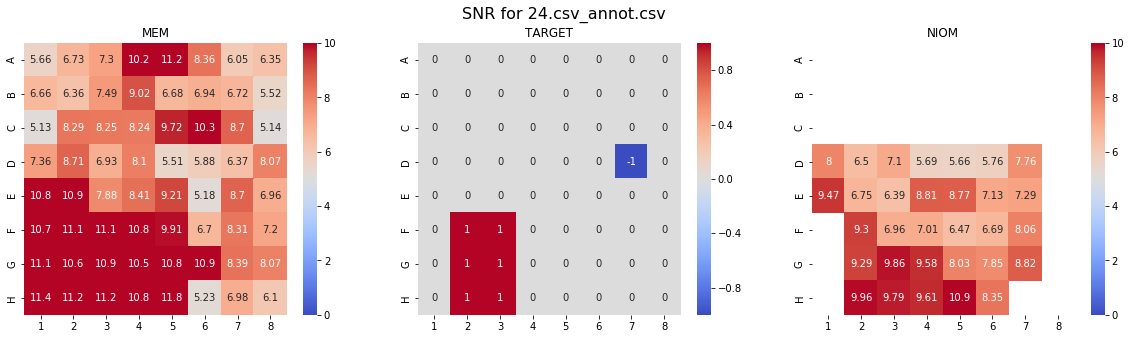

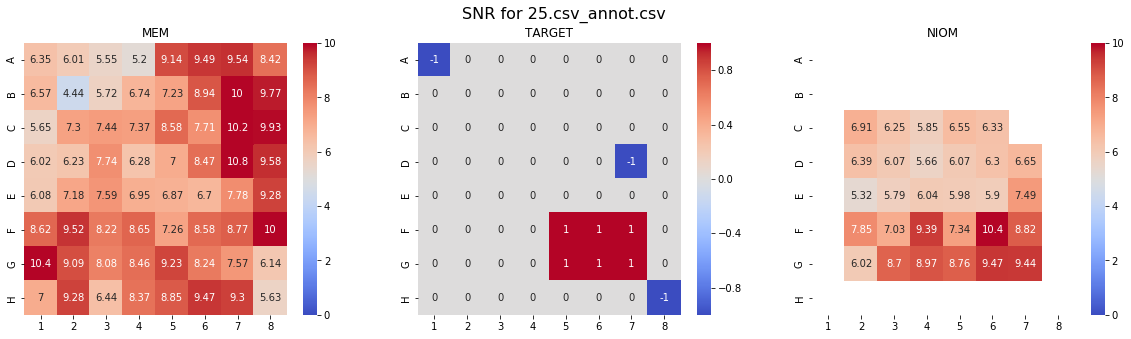

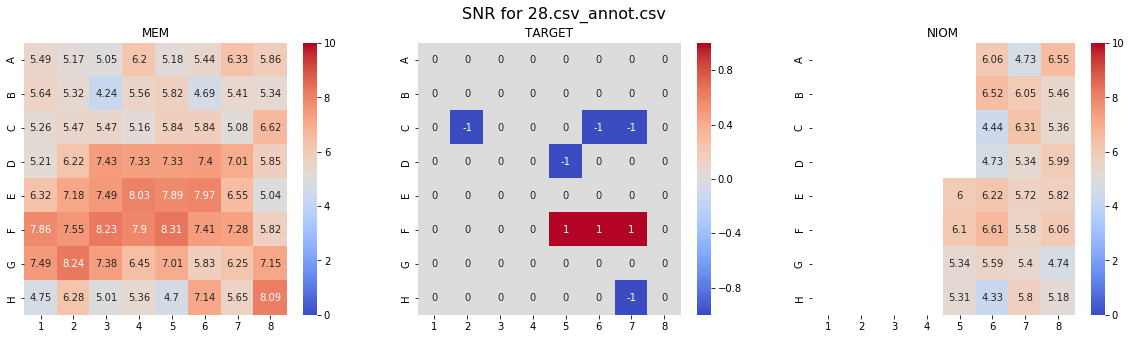

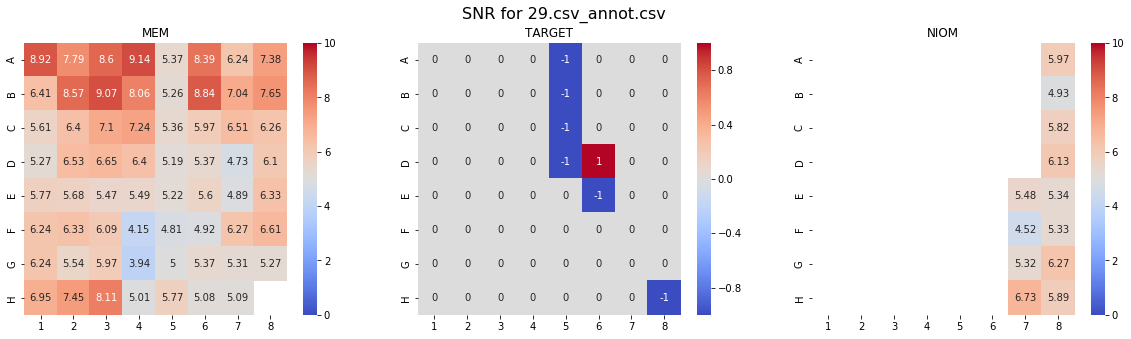

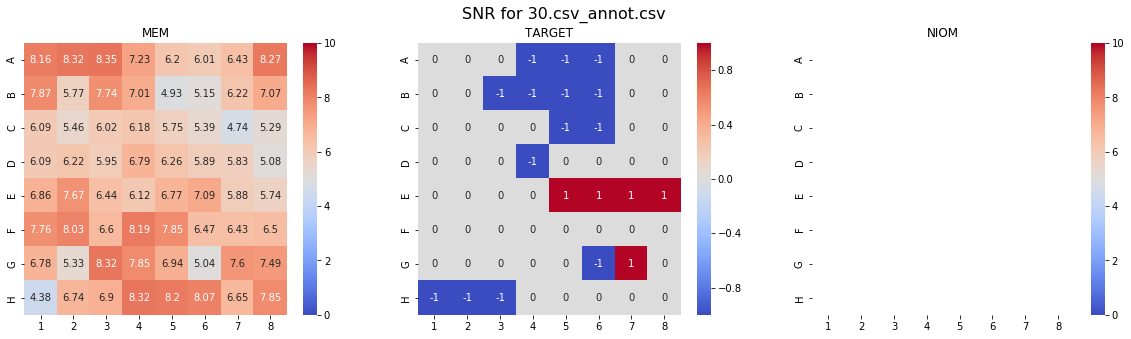

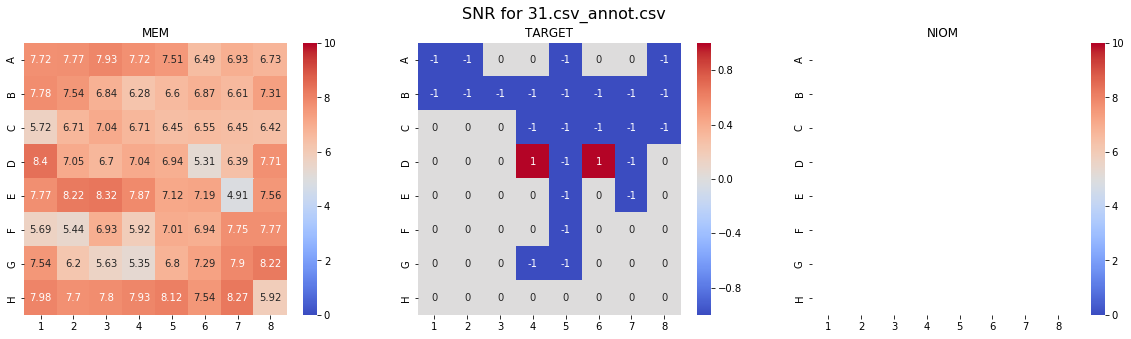

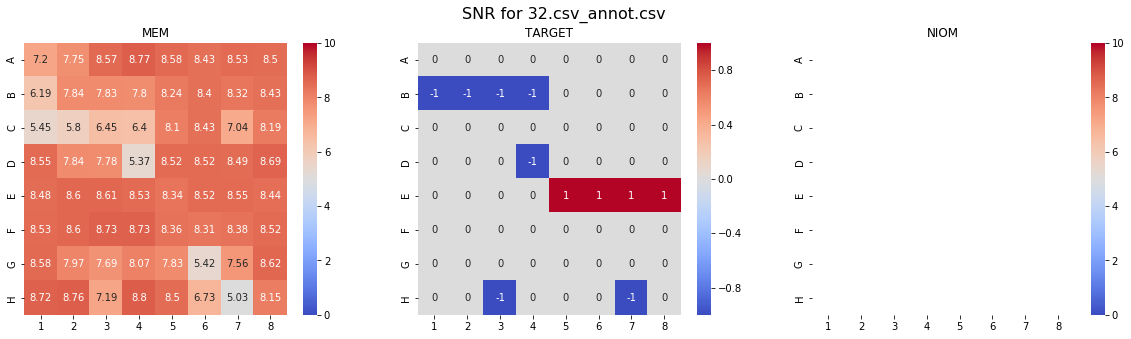

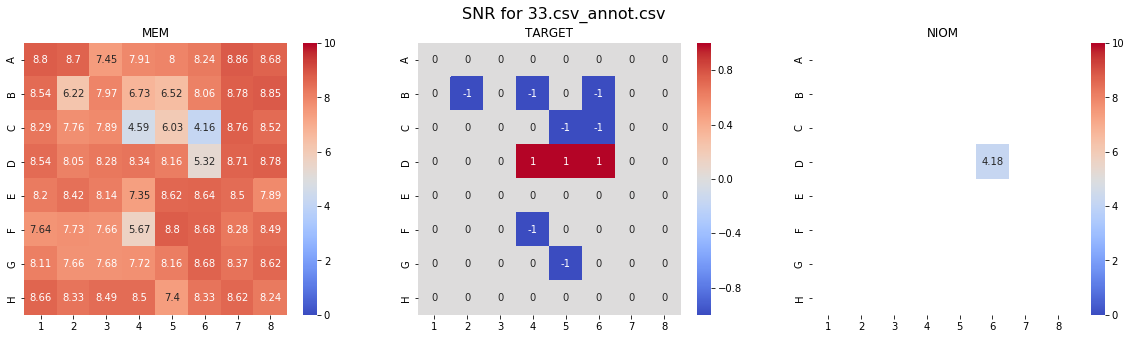

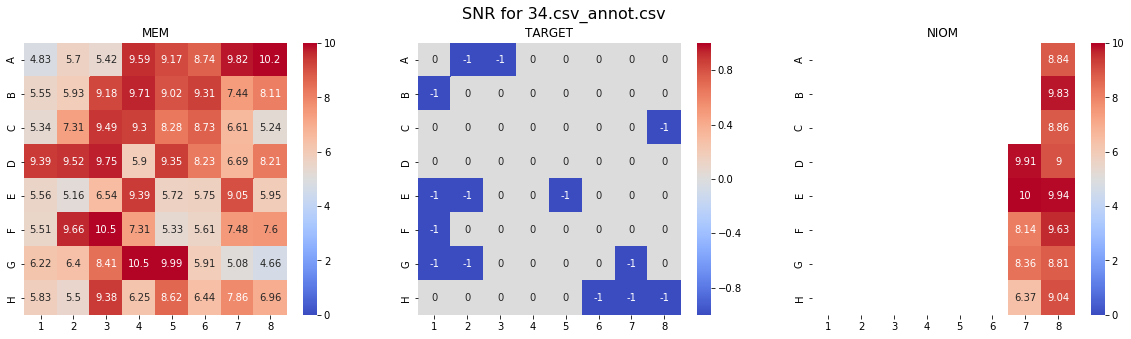

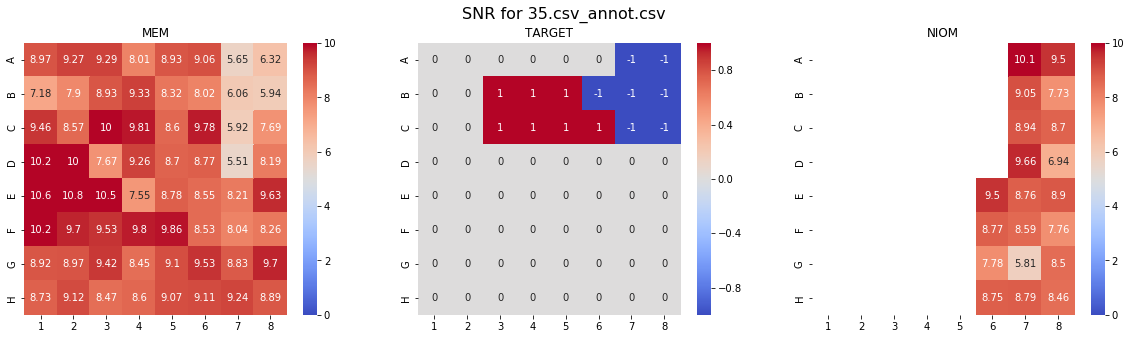

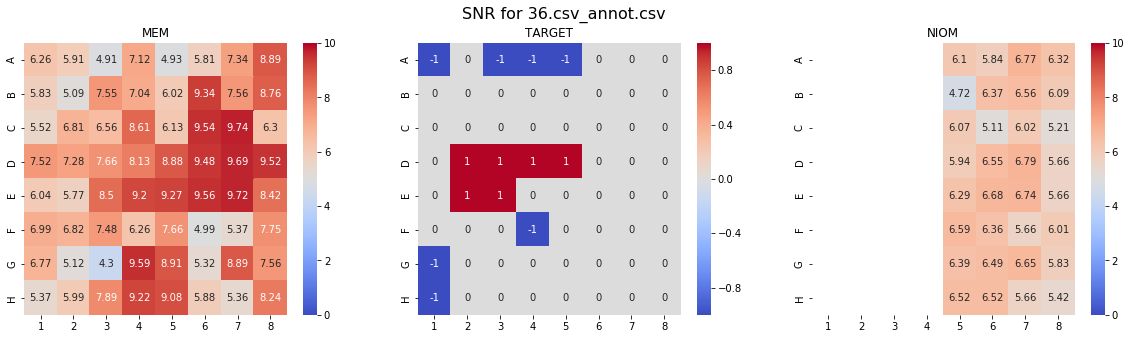

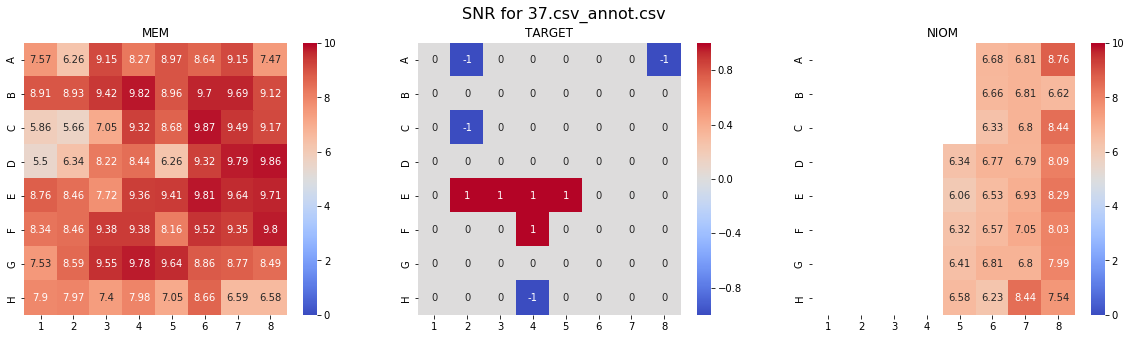

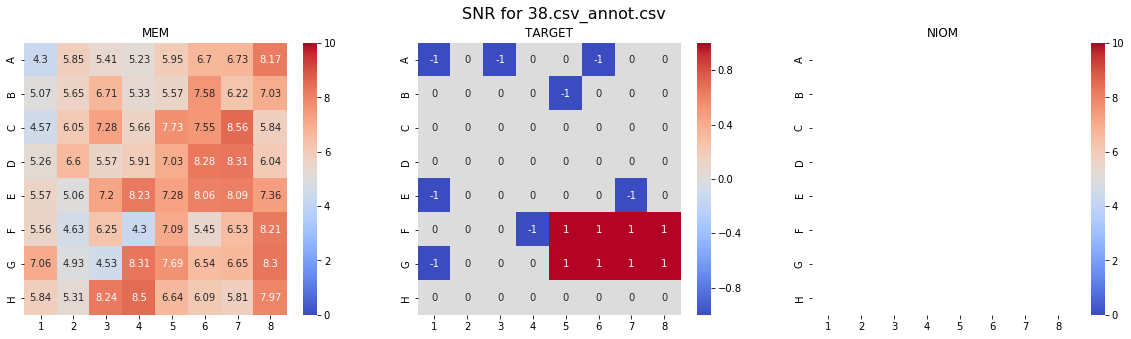

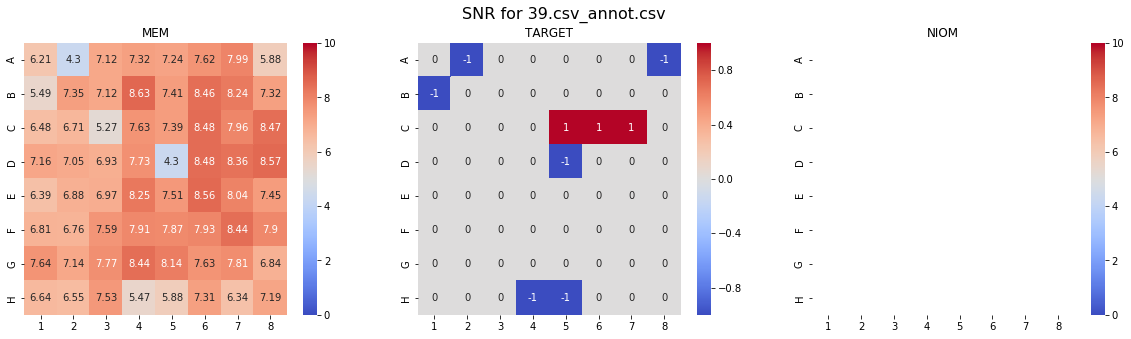

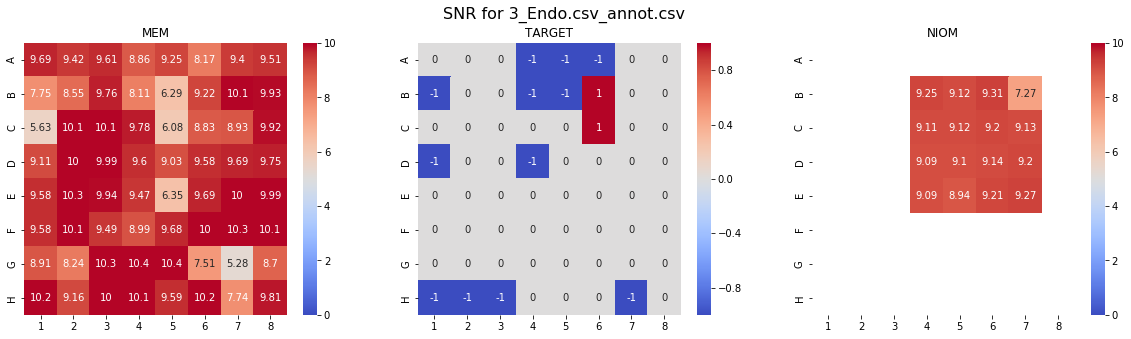

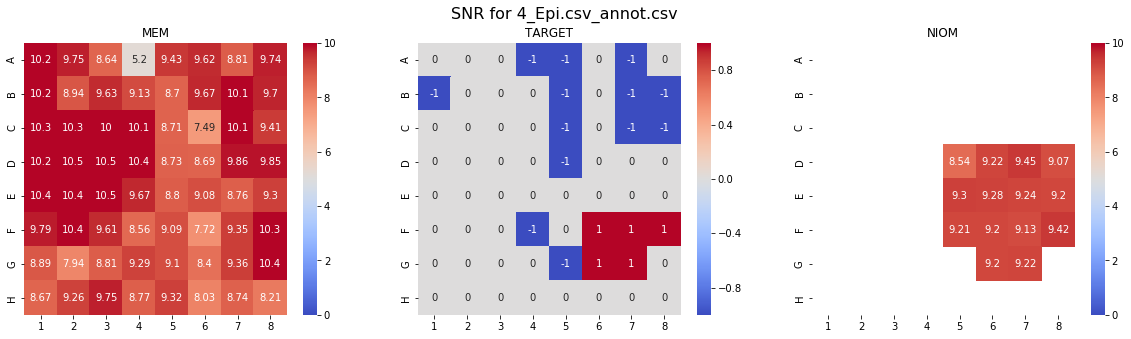

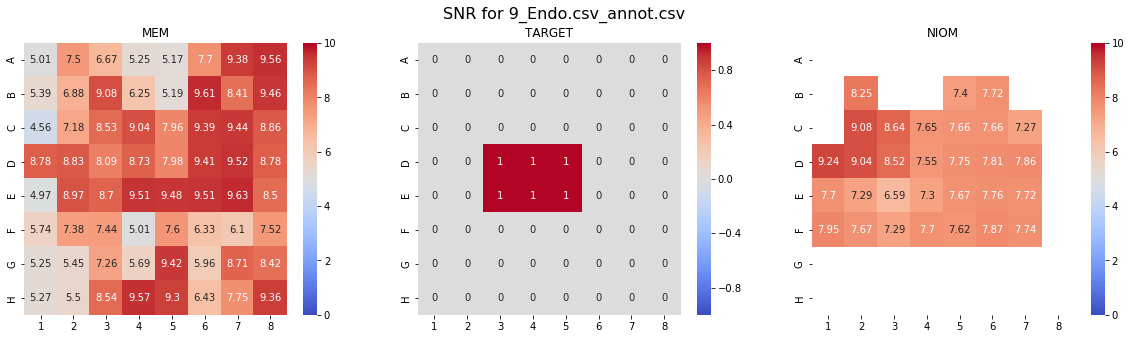

In [53]:
#heatmaps for MEM spectrum for dominant frequency parameter
path = r'C:\Users\ecath\Desktop\Research\Raw Data\LD dataset'
file_names = os.listdir(path)

for i in range(len(mem_spectrum)):
    SNR_mem, target = snr(mem_spectrum[i])
    SNR_niom, _ = snr(niom_spectrum[i])
    
    resized_mem = np.resize(SNR_mem, (8,8)).transpose()
    resized_niom = np.resize(SNR_niom, (8,8)).transpose()

    resized_target = np.resize(target,(8,8)).transpose()

    fig = plt.figure(figsize=(20, 5)) 
    ax1, ax2, ax3 = fig.subplots(1,3)

    fig.suptitle('SNR for ' + file_names[i], fontsize=16)

    pl1 = sns.heatmap(resized_mem, vmin=0, vmax=10, annot=True, 
                        xticklabels=np.arange(1, 9), 
                        yticklabels=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'], 
                        cmap="coolwarm", ax=ax1, fmt='.3g')
    ax1.set_title('MEM')
    
    pl2 = sns.heatmap(resized_niom, vmin=0, vmax=10, annot=True, 
                        xticklabels=np.arange(1, 9), 
                        yticklabels=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'], 
                        cmap="coolwarm", ax=ax3, fmt='.3g')
    
    ax3.set_title('NIOM')
    
    pl3 = sns.heatmap(resized_target, vmin=-1, vmax=1, center=0, annot=True,
                        xticklabels=np.arange(1, 9), 
                        yticklabels=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'], 
                        cmap="coolwarm", ax=ax2)
    
    ax2.set_title('TARGET')
    
    plt.savefig(r'C:\Users\ecath\Desktop\Research\Raw Data' + '\\' + file_names[i] + ' SNR.png', format='png' )

    
    plt.show()
